In [1]:
%matplotlib inline


In [2]:
HELPid="HELP_J095747.72+021353.48"


In [3]:
import argparse
from itertools import product, repeat
from collections import OrderedDict
import sys

from astropy.table import Table

import matplotlib.pyplot as plt
import multiprocessing as mp
import numpy as np
import os
import pkg_resources
from pcigale.data import Database
from scipy.constants import c
from scipy import stats
from pcigale.utils import read_table
import matplotlib.gridspec as gridspec
from scipy.stats import chisquare
from math import log10

# Name of the file containing the best models information
BEST_RESULTS = "results.fits"
# Wavelength limits (restframe) when plotting the best SED.
PLOT_L_MIN = 0.1
PLOT_L_MAX = 5e5

********************

galaxy HELP_J095747.72+021353.48 

at redshift 0.6958923810344089

********************



/opt/anaconda3/lib/python3.5/site-packages/matplotlib/axes/_axes.py:531: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


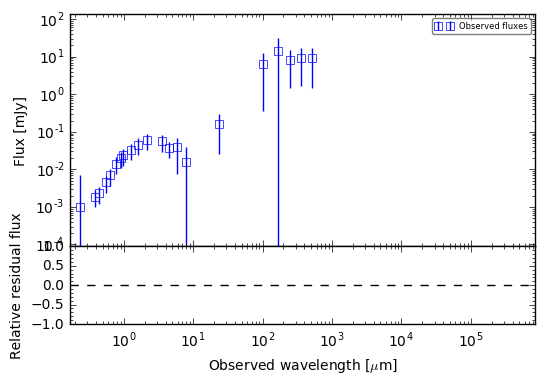

In [4]:
sed = Table.read("{}_best_model.fits".format(HELPid))
obs = Table.read("part_0.fits")
mod=Table.read(BEST_RESULTS)

wavelength_spec = sed['wavelength']
z = obs[obs['id'] == HELPid]['redshift'][0]
DL = mod[obs['id'] == HELPid]['best.universe.luminosity_distance'][0]

print("********************\n")
print("galaxy {} \n".format(HELPid))
print("at redshift {}\n".format(z,decimals=2))
print("********************\n")

obs_fluxes, obs_fluxes_err,filters_wl,mask_ok,mod_fluxes=[],[],[],[],[]
del obs_fluxes[:]
del obs_fluxes_err[:]
del filters_wl[:]
del mask_ok[:]
del mod_fluxes[:]

filters = [item for item in obs.colnames if item not in ('id', 'redshift') and not item.endswith('_err')]
filters_err = [item for item in obs.colnames if item not in ('id', 'redshift') and item.endswith('_err')]

for filt in filters:
    obs_fluxes.append(obs[obs['id'] == HELPid][filt][0])
obs_fluxes=np.array(obs_fluxes)

for filt in filters_err:
    obs_fluxes_err.append(obs[obs['id'] == HELPid][filt][0])

for filt in filters:
    mod_fluxes.append(mod[mod['id'] == HELPid]["best."+filt][0])

with Database() as db:
    for name in filters:
        tmp = db.get_filter(name)
        filters_wl.append(tmp.effective_wavelength/1000.0)

xmin = PLOT_L_MIN * (1. + z)
xmax = PLOT_L_MAX * (1. + z)

k_corr_SED = 1.    

for cname in sed.colnames[1:]:
    sed[cname] *= (wavelength_spec * 1e29 /  (c / (wavelength_spec * 1e-9)) / (4. * np.pi * DL * DL))

wavelength_spec /= 1000.

wsed = np.where((wavelength_spec > xmin) & (wavelength_spec < xmax))

obs_fluxes=np.array(obs_fluxes)
obs_fluxes_err=np.array(obs_fluxes_err)
filters=np.array(filters)
filters_wl=np.array(filters_wl)
mod_fluxes=np.array(mod_fluxes)

plt.close('all')

figure = plt.figure()
gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1])
if (sed.columns[1][wsed] > 0.).any():
    ax1 = plt.subplot(gs[0])
    ax2 = plt.subplot(gs[1])

    ax1.loglog(wavelength_spec[wsed], sed['L_lambda_total'][wsed],
                       label="", color='white', nonposy='clip',
                       linestyle='-', linewidth=0)
     
    mask_ok = np.logical_and(obs_fluxes > 0., obs_fluxes_err > 0.)

    ax1.errorbar(filters_wl[mask_ok], obs_fluxes[mask_ok],
                         yerr=obs_fluxes_err[mask_ok]*3, ls='', marker='s',
                         label='Observed fluxes', markerfacecolor='None',
                         markersize=6, markeredgecolor='b', capsize=0.)

    mask = np.where(obs_fluxes > 0.)
 
    ax2.plot([xmin, xmax], [0., 0.], ls='--', color='k')
    ax2.set_xscale('log')
    ax2.minorticks_on()

    figure.subplots_adjust(hspace=0., wspace=0.)

    ax1.set_xlim(xmin, xmax)
    ymin = min(np.min(obs_fluxes[mask_ok]),
                       np.min(mod_fluxes[mask_ok]))
    ymax = max(np.max(obs_fluxes[mask_ok]),
                           np.max(mod_fluxes[mask_ok]))
    ax1.set_ylim(1e-1*ymin, 1e1*ymax)
    ax2.set_xlim(xmin, xmax)
    ax2.set_ylim(-1.0, 1.0)

    ax2.set_xlabel("Observed wavelength [$\mu$m]")
    ax1.set_ylabel("Flux [mJy]")
    ax2.set_ylabel("Relative residual flux")
    ax1.legend(fontsize=6, loc='best', fancybox=True, framealpha=0.5)
    ax2.legend(fontsize=6, loc='best', fancybox=True, framealpha=0.5)
    plt.setp(ax1.get_xticklabels(), visible=False)
    plt.setp(ax1.get_yticklabels()[1], visible=False)
    


In order to	define the best modules to be used	within HELP we have run CIGALE with different modules and parameters:

* <strong>Star Formation History</strong>: delayed star formation history with an additional, almost flat, burst,
  * $\tau$ e-folding time of the main stellar population model [Myr] :  3000
  *	e-folding time of the late starburst population model [Myr] : 10 000
  * mass fract. of the late burst population : 0.0, 0.005, 0.01, 0.05, 0.1, 0.15,  0.20, 0.3
  * age [Myr] :   1000, 2000, 3000, 3500, 4000, 5000, 6500, 10000
  * age of the late burst [Myr] :  10.0, 30.0, 50., 70.
* <strong>Single Stellar Population</strong>: Bruzual & Charlot 2003
  * initial mass function : Chabrier 2003
  * metallicities (solar metallicity) : 0.2 
  * age of the separation between the young and the old star population [Myr] : 10 
* <strong>Dust attenuation</strong>: Charlot & Fall 2000,
  * V-band attenuation in the birth clouds (Av BC) : 0.12,0.25, 0.5, 0.8,1.2,1.7,2.3,2.8,3.3, 3.8, 4.0   
  * power law slope of the attenuation in the birth clouds : -0.7 
  * BC to ISM factor : 0.44 
  * power law slope of the attenuation in the ISM : -0.7 
* <strong>Dust emission</strong>:  Drain & Li 2007
  * mass fraction of PAH :  0.47, 1.12, 2.5, 3.9
  * minimum radiation field (umin) : 5.0, 10.0, 25.0
  * power law slope dU/dM  ($U^{\alpha}$) : 2.0, 2.8
  * fraction illuminated from Umin to Umax ($\gamma$) : 0.005, 0.02, 0.05
* <strong>AGN emission</strong>: Fritz 2006 
  * ratio of the maximum to minimum radius of the dust torus : 60 
  * optical depth at 9.7 microns : 1.0, 6.0
  * radial dust distribution in the torus : -0.5 
  * angular dust distribution in the torus : 0.0 
  * angular opening angle of the torus [deg] : 100.0 
  * angle between equatorial axis and the line of sight [deg] : 0.001  
  * fractional contribution of AGN: 0.0, 0.1, 0.15, 0.25, 0.4

The quality of the fitted SEDs is calculated making use of the $\chi^2$ value of the best model, marginalized over all parameters except the one assigned for the further physical analysis. The final output values of analyzed parameters are calculated as the mean  and standard deviation determined from the PDFs. 

Firstly CIGALE serach for the best parameters for each modules from the given ones. At the end, based on the PDF analysis, final quanitities are computed.

####################################################################################################################

### MAIN BEST RESULTS FOR STELLAR PART OF THE SPECTRA AND ATTENUATION:

In [5]:
print("stellar mass: {} [stellar mass]".format(log10(mod[obs['id'] == HELPid]['best.stellar.m_star'][0])))
print("V-band attenuation in the birth clouds: {} ".format((mod[obs['id'] == HELPid]['best.attenuation.Av_BC'][0])))
print("attenuation in FUV band: {} [mag]".format((mod[obs['id'] == HELPid]['best.attenuation.FUV'][0])))
print("attenuation in V band: {} [mag]".format((mod[obs['id'] == HELPid]['best.attenuation.V_B90'][0])))


stellar mass: 10.811871912145174 [stellar mass]
V-band attenuation in the birth clouds: 1.7 
attenuation in FUV band: 2.7506744850892115 [mag]
attenuation in V band: 0.8275122519216239 [mag]


#### Below on the plot stellar components (attenuated and unattenuated) are plotted against observed fluxes:

/opt/anaconda3/lib/python3.5/site-packages/matplotlib/axes/_axes.py:531: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


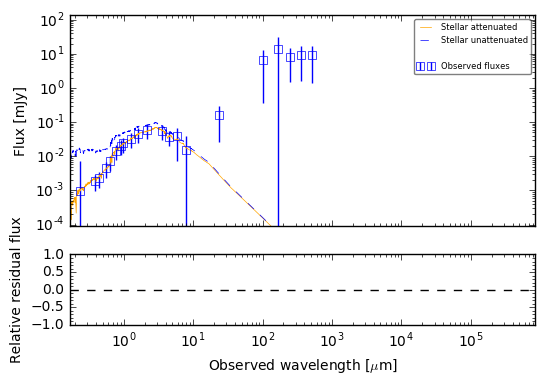

In [6]:
if (sed.columns[1][wsed] > 0.).any():
    ax1 = plt.subplot(gs[0])
    ax2 = plt.subplot(gs[1])

    ax1.loglog(wavelength_spec[wsed], (sed['stellar.young'][wsed] + sed['attenuation.stellar.young'][wsed] + 
               sed['stellar.old'][wsed] + sed['attenuation.stellar.old'][wsed]), 
               label="Stellar attenuated ", color='orange', marker=None, nonposy='clip', linestyle='-', linewidth=0.5)
    ax1.loglog(wavelength_spec[wsed], (sed['stellar.old'][wsed] +  sed['stellar.young'][wsed]), 
               label="Stellar unattenuated", color='b', marker=None, nonposy='clip', linestyle='--', linewidth=0.5)
    ax1.loglog(wavelength_spec[wsed], sed['L_lambda_total'][wsed], label=" ", color='white', nonposy='clip', 
               linestyle='-', linewidth=0)

    ax1.set_autoscale_on(False)
    mask_ok = np.logical_and(obs_fluxes > 0., obs_fluxes_err > 0.)
    ax1.errorbar(filters_wl[mask_ok], obs_fluxes[mask_ok], yerr=obs_fluxes_err[mask_ok]*3, ls='', marker='s', 
                 label='Observed fluxes', markerfacecolor='None',markersize=6, markeredgecolor='b', capsize=0.)

    mask = np.where(obs_fluxes > 0.)
    ax2.plot([xmin, xmax], [0., 0.], ls='--', color='k')
    ax2.set_xscale('log')
    ax2.minorticks_on()

    figure.subplots_adjust(hspace=0., wspace=0.)

    ax1.set_xlim(xmin, xmax)
    ymin = min(np.min(obs_fluxes[mask_ok]), np.min(mod_fluxes[mask_ok]))
    ymax = max(np.max(obs_fluxes[mask_ok]), np.max(mod_fluxes[mask_ok]))
    ax1.set_ylim(1e-1*ymin, 1e1*ymax)
    ax2.set_xlim(xmin, xmax)
    ax2.set_ylim(-1.0, 1.0)

    ax2.set_xlabel("Observed wavelength [$\mu$m]")
    ax1.set_ylabel("Flux [mJy]")
    ax2.set_ylabel("Relative residual flux")
    ax1.legend(fontsize=6, loc='best', fancybox=True, framealpha=0.5)
    ax2.legend(fontsize=6, loc='best', fancybox=True, framealpha=0.5)
    plt.setp(ax1.get_xticklabels(), visible=False)
    plt.setp(ax1.get_yticklabels()[1], visible=False)
    

### MAIN BEST RESULTS FOR DUST EMISSION:

In [7]:
print("power law slope dU/dM (alpha) : {}".format((mod[obs['id'] == HELPid]['best.dust.alpha'][0])))
print("fraction illuminated from Umin to Umax (gamma): {} ".format((mod[obs['id'] == HELPid]['best.dust.gamma'][0])))
print("mass fraction of PAH: {} ".format((mod[obs['id'] == HELPid]['best.dust.qpah'][0])))
print("minimum radiation field: {} ".format((mod[obs['id'] == HELPid]['best.dust.umin'][0])))
print("best dust luminosity: {} [stellar luminosity]".format(log10((mod[obs['id'] == HELPid]['best.dust.luminosity'][0])/(3.846*pow(10,26)))))

power law slope dU/dM (alpha) : 2.0
fraction illuminated from Umin to Umax (gamma): 0.02 
mass fraction of PAH: 0.47 
minimum radiation field: 5.0 
best dust luminosity: 11.199383902029156 [stellar luminosity]


#### Below on the plot dust component is  plotted against observed fluxes:

Tutaj


/opt/anaconda3/lib/python3.5/site-packages/matplotlib/axes/_axes.py:531: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


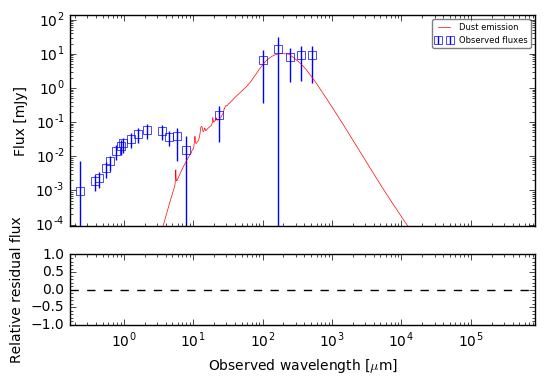

In [8]:
if (sed.columns[1][wsed] > 0.).any():
    print("Tutaj")
    ax1 = plt.subplot(gs[0])
    ax2 = plt.subplot(gs[1])
    ax1.loglog(wavelength_spec[wsed],
                           (sed['dust.Umin_Umin'][wsed] +
                            sed['dust.Umin_Umax'][wsed]),
                           label="Dust emission", color='r', marker=None,
                           nonposy='clip', linestyle='-', linewidth=0.5)
    ax1.loglog(wavelength_spec[wsed], sed['L_lambda_total'][wsed],
                       label="", color='white', nonposy='clip',
                       linestyle='-', linewidth=0)

    mask_ok = np.logical_and(obs_fluxes > 0., obs_fluxes_err > 0.)
    ax1.errorbar(filters_wl[mask_ok], obs_fluxes[mask_ok],
                         yerr=obs_fluxes_err[mask_ok]*3, ls='', marker='s',
                         label='Observed fluxes', markerfacecolor='None',
                         markersize=6, markeredgecolor='b', capsize=0.)

    mask = np.where(obs_fluxes > 0.)
    #ax2.errorbar(filters_wl[mask],
    #                     (obs_fluxes[mask]-mod_fluxes[mask])/obs_fluxes[mask],
    #                     yerr=obs_fluxes_err[mask]/obs_fluxes[mask]*3,
    #                     marker='_', label="(Obs-Mod)/Obs", color='k',
    #                     capsize=0.)
    ax2.plot([xmin, xmax], [0., 0.], ls='--', color='k')
    ax2.set_xscale('log')
    ax2.minorticks_on()

    figure.subplots_adjust(hspace=0., wspace=0.)

    ax1.set_xlim(xmin, xmax)
    ymin = min(np.min(obs_fluxes[mask_ok]),
                       np.min(mod_fluxes[mask_ok]))
    ymax = max(np.max(obs_fluxes[mask_ok]),
                           np.max(mod_fluxes[mask_ok]))
    ax1.set_ylim(1e-1*ymin, 1e1*ymax)
    ax2.set_xlim(xmin, xmax)
    ax2.set_ylim(-1.0, 1.0)

    ax2.set_xlabel("Observed wavelength [$\mu$m]")
    ax1.set_ylabel("Flux [mJy]")
    ax2.set_ylabel("Relative residual flux")
    ax1.legend(fontsize=6, loc='best', fancybox=True, framealpha=0.5)
    ax2.legend(fontsize=6, loc='best', fancybox=True, framealpha=0.5)
    plt.setp(ax1.get_xticklabels(), visible=False)
    plt.setp(ax1.get_yticklabels()[1], visible=False)
    

### MAIN BEST RESULTS FOR AGN component:

In [9]:
print("best fraction of AGN : {}".format((mod[obs['id'] == HELPid]['best.agn.fracAGN'][0])))
if mod[obs['id'] == HELPid]['best.agn.fracAGN'][0]>0:
    print("best AGN liminosity: {} [stellar luminosity]".format(log10((mod[obs['id'] == HELPid]['best.agn.luminosity'][0])/(3.846*pow(10,26)))))




best fraction of AGN : 0.0


In [10]:
if mod[obs['id'] == HELPid]['best.agn.fracAGN'][0]>0:

    if (sed.columns[1][wsed] > 0.).any():
        ax1 = plt.subplot(gs[0])
        ax2 = plt.subplot(gs[1])

        ax1.loglog(wavelength_spec[wsed],(sed['agn.fritz2006_therm'][wsed] + sed['agn.fritz2006_scatt'][wsed] + 
                    sed['agn.fritz2006_agn'][wsed]),label="AGN emission", color='g', marker=None, nonposy='clip', linestyle='-', linewidth=0.5)
        ax1.loglog(wavelength_spec[wsed], sed['L_lambda_total'][wsed], label="", color='white', nonposy='clip',
                       linestyle='-', linewidth=0)

        mask_ok = np.logical_and(obs_fluxes > 0., obs_fluxes_err > 0.)
        ax1.errorbar(filters_wl[mask_ok], obs_fluxes[mask_ok], yerr=obs_fluxes_err[mask_ok]*3, ls='', marker='s',
                label='Observed fluxes', markerfacecolor='None',markersize=6, markeredgecolor='b', capsize=0.)

        mask = np.where(obs_fluxes > 0.)

        ax2.plot([xmin, xmax], [0., 0.], ls='--', color='k')
        ax2.set_xscale('log')
        ax2.minorticks_on()

        figure.subplots_adjust(hspace=0., wspace=0.)

        ax1.set_xlim(xmin, xmax)
        ymin = min(np.min(obs_fluxes[mask_ok]), np.min(mod_fluxes[mask_ok]))
        ymax = max(np.max(obs_fluxes[mask_ok]), np.max(mod_fluxes[mask_ok]))
        ax1.set_ylim(1e-1*ymin, 1e1*ymax)
        ax2.set_xlim(xmin, xmax)
        ax2.set_ylim(-1.0, 1.0)

        ax2.set_xlabel("Observed wavelength [$\mu$m]")
        ax1.set_ylabel("Flux [mJy]")
        ax2.set_ylabel("Relative residual flux")
        ax1.legend(fontsize=6, loc='best', fancybox=True, framealpha=0.5)
        ax2.legend(fontsize=6, loc='best', fancybox=True, framealpha=0.5)
        plt.setp(ax1.get_xticklabels(), visible=False)
        plt.setp(ax1.get_yticklabels()[1], visible=False)
else: 
    print("best fraction of AGN : {}".format((mod[obs['id'] == HELPid]['best.agn.fracAGN'][0])))
    

best fraction of AGN : 0.0


### In the last step all modules are merge together to computed one best model (based on the $\chi^2$) marked as a black line in the figure below. 

Modeled fluxes for each filter used for SED fitting are calculated based on the best model. The relative residual fluxes are ploted in the bottom panel of the figure. 

Final $\chi^2$ value as well as main physical parameters computed based on PDF analysis are listed below:


In [11]:
print("reduced $\chi^2$ : {} ".format((mod[obs['id'] == HELPid]['best.reduced_chi_square'][0])))
print("bayesian stellar mass {} +/- {} [M sun]:".format(log10(mod[obs['id'] == HELPid]['bayes.stellar.m_star'][0]),0.434*(mod[obs['id'] == HELPid]['bayes.stellar.m_star'][0])/(mod[obs['id'] == HELPid]['bayes.stellar.m_star_err'][0])))
print("bayesian dust luminosity: {} +/- {} [L sun]".format(log10((mod[obs['id'] == HELPid]['bayes.dust.luminosity'][0])/(3.846*pow(10,26))),0.434*(mod[obs['id'] == HELPid]['bayes.dust.luminosity'][0])/(mod[obs['id'] == HELPid]['bayes.dust.luminosity_err'][0])))
print("bayesian SFR {} +/- {} [M sun / yr]:".format((mod[obs['id'] == HELPid]['bayes.sfh.sfr10Myrs'][0]),(mod[obs['id'] == HELPid]['bayes.sfh.sfr10Myrs_err'][0])))
print("bayesian AGN fraction {} +/- {}:".format((mod[obs['id'] == HELPid]['bayes.agn.fracAGN'][0]),(mod[obs['id'] == HELPid]['bayes.agn.fracAGN_err'][0])))

reduced $\chi^2$ : 0.6773938902916605 
bayesian stellar mass 10.780886769559045 +/- 3.364478045074963 [M sun]:
bayesian dust luminosity: 11.232695851639296 +/- 2.843564187753497 [L sun]
bayesian SFR 16.215375774529605 +/- 2.5427437135289894 [M sun / yr]:
bayesian AGN fraction 1.3516930515065185e-05 +/- 0.001164416553238685:


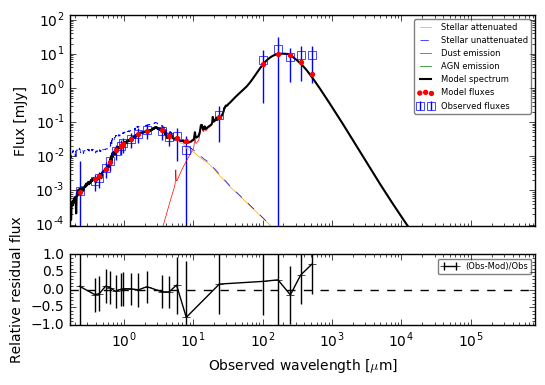

In [12]:
if (sed.columns[1][wsed] > 0.).any():
    ax1 = plt.subplot(gs[0])
    ax2 = plt.subplot(gs[1])
    # Stellar emission
    ax1.loglog(wavelength_spec[wsed], (sed['stellar.young'][wsed] + sed['attenuation.stellar.young'][wsed] + 
               sed['stellar.old'][wsed] + sed['attenuation.stellar.old'][wsed]), label="Stellar attenuated ", 
               color='orange', marker=None, nonposy='clip', linestyle='-',linewidth=0.5)
    ax1.loglog(wavelength_spec[wsed],(sed['stellar.old'][wsed] + sed['stellar.young'][wsed]), 
               label="Stellar unattenuated", color='b', marker=None,nonposy='clip', linestyle='--', linewidth=0.5)
    #Dust emission
    ax1.loglog(wavelength_spec[wsed], (sed['dust.Umin_Umin'][wsed] + sed['dust.Umin_Umax'][wsed]), 
               label="Dust emission", color='r', marker=None, nonposy='clip', linestyle='-', linewidth=0.5)
    # AGN emission Fritz
    if 'agn.fritz2006_therm' in sed.columns:
        ax1.loglog(wavelength_spec[wsed], (sed['agn.fritz2006_therm'][wsed] + sed['agn.fritz2006_scatt'][wsed] + 
                sed['agn.fritz2006_agn'][wsed]), label="AGN emission", color='g', marker=None, nonposy='clip', 
                   linestyle='-', linewidth=0.5)

    ax1.loglog(wavelength_spec[wsed], sed['L_lambda_total'][wsed], label="Model spectrum", color='k', nonposy='clip',
                       linestyle='-', linewidth=1.5)

    ax1.set_autoscale_on(False)
    ax1.scatter(filters_wl, mod_fluxes, marker='o', color='r', s=8,zorder=3, label="Model fluxes")
    mask_ok = np.logical_and(obs_fluxes > 0., obs_fluxes_err > 0.)
    ax1.errorbar(filters_wl[mask_ok], obs_fluxes[mask_ok], yerr=obs_fluxes_err[mask_ok]*3, ls='', marker='s', 
                 label='Observed fluxes', markerfacecolor='None', markersize=6, markeredgecolor='b', capsize=0.)

    mask = np.where(obs_fluxes > 0.)
    ax2.errorbar(filters_wl[mask],(obs_fluxes[mask]-mod_fluxes[mask])/obs_fluxes[mask],  
                 yerr=obs_fluxes_err[mask]/obs_fluxes[mask]*3, marker='_', label="(Obs-Mod)/Obs", color='k', capsize=0.)
    ax2.plot([xmin, xmax], [0., 0.], ls='--', color='k')
    ax2.set_xscale('log')
    ax2.minorticks_on()

    figure.subplots_adjust(hspace=0., wspace=0.)

    ax1.set_xlim(xmin, xmax)
    ymin = min(np.min(obs_fluxes[mask_ok]),np.min(mod_fluxes[mask_ok]))
    ymax = max(np.max(obs_fluxes[mask_ok]),np.max(mod_fluxes[mask_ok]))
    ax1.set_ylim(1e-1*ymin, 1e1*ymax)
    ax2.set_xlim(xmin, xmax)
    ax2.set_ylim(-1.0, 1.0)

    ax2.set_xlabel("Observed wavelength [$\mu$m]")
    ax1.set_ylabel("Flux [mJy]")
    ax2.set_ylabel("Relative residual flux")
    ax1.legend(fontsize=6, loc='best', fancybox=True, framealpha=0.5)
    ax2.legend(fontsize=6, loc='best', fancybox=True, framealpha=0.5)
    plt.setp(ax1.get_xticklabels(), visible=False)
    plt.setp(ax1.get_yticklabels()[1], visible=False)
    